In [3]:
import bitermplus as btm
from gensim import corpora
from gensim.models import LdaModel
from spacy import load
import kagglehub
import pandas as pd
import numpy as np
import os
import tmplot as tmp
from gensim.models import CoherenceModel
import seaborn as sns
import matplotlib.pyplot as plt

### Download datasets

In [4]:
movie_dataset_path = kagglehub.dataset_download(
    "rajathmc/cornell-moviedialog-corpus"
)

In [5]:
simpsons_dataset_path = kagglehub.dataset_download(
    "pierremegret/dialogue-lines-of-the-simpsons"
)

In [6]:
with open(os.path.join(movie_dataset_path, "movie_lines.txt"), encoding="iso-8859-1") as f:
    movie_texts = [line.split(" +++$+++ ")[-1].strip() for line in f]

In [7]:
simpsons_texts = pd.read_csv(os.path.join(simpsons_dataset_path, "simpsons_dataset.csv"))["spoken_words"].dropna().tolist()

In [8]:
len(movie_texts)

304713

In [9]:
movie_texts[:10]

['They do not!',
 'They do to!',
 'I hope so.',
 'She okay?',
 "Let's go.",
 'Wow',
 "Okay -- you're gonna need to learn how to lie.",
 'No',
 'I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?',
 'Like my fear of wearing pastels?']

In [10]:
len(simpsons_texts)

131855

In [11]:
simpsons_texts[:10]

["No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it.",
 "Where's Mr. Bergstrom?",
 "I don't know. Although I'd sure like to talk to him. He didn't touch my lesson plan. What did he teach you?",
 'That life is worth living.',
 "The polls will be open from now until the end of recess. Now, just in case any of you have decided to put any thought into this, we'll have our final statements. Martin?",
 "I don't think there's anything left to say.",
 'Bart?',
 'Victory party under the slide!',
 'Mr. Bergstrom! Mr. Bergstrom!',
 'Hey, hey, he Moved out this morning. He must have a new job -- he took his Copernicus costume.']

### Preprocessing

In [12]:
nlp = load("en_core_web_sm", disable=["parser", "ner"])

In [13]:
STOP_WORDS = nlp.Defaults.stop_words

In [14]:
def preprocess_text(text: str) -> list[str]:
    document = nlp(text.lower())
    return [
        token.lemma_ for token in document
        if token.is_alpha and token.lemma_ not in STOP_WORDS and len(token) > 2
    ]

In [15]:
texts = simpsons_texts

In [16]:
tokens = [t for t in map(preprocess_text, texts) if len(t) >= 3]

In [17]:
t_values = [n for n in range(4, 4 * 5 + 1, 4)]

### LDA

In [18]:
dictionary = corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=10, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in tokens]

In [19]:
lda_coherences = []
lda_perplexities = []
lda_models_by_t = {}

In [20]:
for num_topics in t_values:
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=10,
        random_state=99,
    )
    cm = CoherenceModel(
        model=lda,
        texts=tokens,
        dictionary=dictionary,
        coherence='c_v'
    )
    coh = cm.get_coherence()
    lda_coherences.append(coh)
    perp = lda.log_perplexity(corpus)
    lda_perplexities.append(np.exp(-perp))
    lda_models_by_t[num_topics] = lda

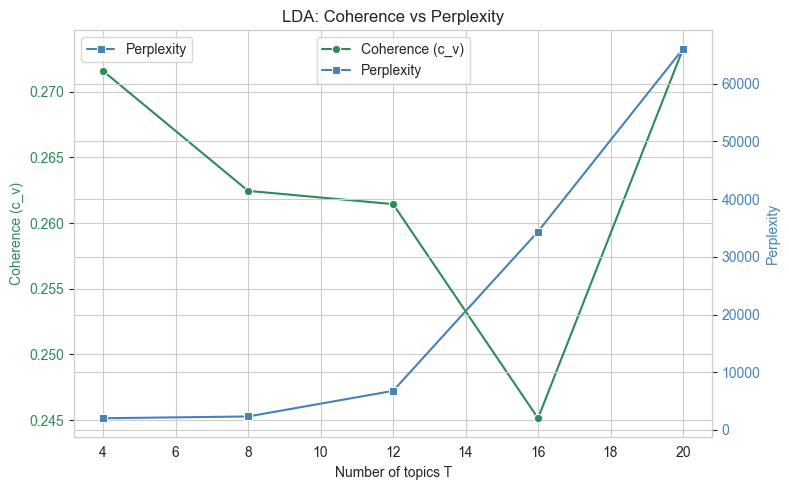

In [21]:
df = pd.DataFrame(
    {
        "T": t_values,
        "Coherence": lda_coherences,
        "Perplexity": lda_perplexities
    }
)

sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(8, 5))
sns.lineplot(
    data=df, x="T", y="Coherence",
    marker="o", color="seagreen", label="Coherence (c_v)",
    ax=ax1
)
ax1.set_xlabel("Number of topics T")
ax1.set_ylabel("Coherence (c_v)", color="seagreen")
ax1.tick_params(axis="y", labelcolor="seagreen")

ax2 = ax1.twinx()
sns.lineplot(
    data=df, x="T", y="Perplexity",
    marker="s", color="steelblue", label="Perplexity",
    ax=ax2
)
ax2.set_ylabel("Perplexity", color="steelblue")
ax2.tick_params(axis="y", labelcolor="steelblue")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper center")

plt.title("LDA: Coherence vs Perplexity")
plt.tight_layout()
plt.show()

### LDA

In [22]:
tmp.report(lda_models_by_t[12], docs=texts, corpus=corpus)

### BTM

In [23]:
docs_text = [" ".join(doc) for doc in tokens]

In [24]:
X, vocabulary, vocab_dict = btm.get_words_freqs(docs_text)

In [25]:
docs_vec = btm.get_vectorized_docs(docs_text, vocabulary)
biterms = btm.get_biterms(docs_vec)

In [26]:
btm_model = btm.BTM(
    X,
    vocabulary,
    T=12,
    M=20,
    alpha=50 / 12,
    beta=0.01,
    seed=42
)
btm_model.fit(biterms, iterations=100)

100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


In [27]:
tmp.report(btm_model, docs=docs_text)

/Users/bezstrok/Projects/Research-EDA/.venv/lib/python3.12/site-packages/tmplot/_helpers.py:268: RuntimeWarning: invalid value encountered in divide
  p_t /= p_t.sum()
